# Clustering Geologic Data using the SeisWare SDK

### <a href='#lasimport'>(Or an LAS file)</a>

Today I'll be going over how to pull log curve data from a SeisWare project and apply a few different clustering algorithms available in scikit-learn.

This is going to involve using the SeisWare SDK, and all the code is going to be done in Python.


![https://scikit-learn.org/stable/](scikit-learn-logo-notext.png "Scikit-learn logo")

<a href='#https://scikit-learn.org/'><center>https://scikit-learn.org/</center></a>

Here's what I'll be going over:
    
    1. Connecting to a SeisWare project
    2. Getting a well object
    3. Getting the log curves from that well into a DataFrame
    4. Plot the logs in a simple plot
    5. Survey the data with a pair plot
    6. Run through multiple different clustering algorithms with the data and show the results
    7. Choose a single algorithm and return a curve containing the clusters as a curve
    8. Bring that curve back into SeisWare and display the clusters
    
 I'll also talk about how steps 1-3 can be replaced for a generic LAS file, and how to output a new LAS file containing the cluster values.

The first thing I'll do is import SeisWare and another library. All of the code you're seeing today will be available on this github repo

 https://github.com/markogauk/Clustering_Webinar
 
 
If you don't have the SeisWare SDK, or don't care about that part, click <a href='#lasimport'>here</a> to skip to where we use an LAS file.

In [1]:
import SeisWare
import SWconnect

import SeisWare brings in the main SeisWare SDK library. To save time and to help simplify things, I've also included some functions from the SWconnect file. This way I don't have to waste time repeating some of the same operations.

First I'm going to load my project and define my depth units.

In [3]:
login_instance = SWconnect.SWconnect("TeaPot-Demoset")
depth_unit = SeisWare.Unit.Foot

Now that I've got my login instance of the project, lets take a look at a well

In [4]:
well = SWconnect.getWell("490250634800",login_instance)
print(well.UWI())

490250634800


In [5]:
def get_log_curve_names(well,login_instance):
    '''
    Return all the names of log curves for a given well
    
    well: SeisWare Well Object
    
    login_instance: SeisWare login instance to project
    
    Returns: List of log curve names that exist for the well
    
    '''
    log_curve_list = SeisWare.LogCurveList()
    
    login_instance.LogCurveManager().GetAllForWell(well.ID(), log_curve_list)
    
    log_curves = [log_curve.Name() for log_curve in log_curve_list]
    
    
    return log_curves

In [6]:
print(get_log_curve_names(well,login_instance))

['SPR', 'DT', 'ILD', 'CALS', 'ASN', 'GR', 'CILD']


In order to organize my log curve data, I'm going to load it all into a library called **Pandas**. I can load the data into something called a DataFrame, and from there it will be easy to manipulate or run clustering.

First I'll import the library.

In [7]:
import pandas as pd

Log curves in the SDK are stored based on a top depth, and depth increment. To get the log curves in a useful format, I can go through the list of values and build a table of depth, value pairs.

Then I can put the values into a DataFrame indexed by depth.

In [8]:
def log_value_fill(log_curve):
    '''
    Take a log curve object and return a dataframe containing the depths and curve values
    
    log_curve: SeisWare log curve object
    
    Returns: DataFrame indexed on MD. Index name DEPT, column name based on Log Curve
    '''
    
    login_instance.LogCurveManager().PopulateValues(log_curve)
    
    log_curve_values = SeisWare.DoublesList()
    
    log_curve.Values(log_curve_values)
    
    log_list = []
    
    # Go through all the values in a log curve and return them as a (depth,value) pair.
    
    for i,values in enumerate(log_curve_values):
        log_list.append(((log_curve.TopDepth()+log_curve.DepthInc()*i).Value(depth_unit),values))     
  
    # Return a dataframe indexed on MD with the corresponding value
    
    return pd.DataFrame(log_list,columns = ['DEPT',log_curve.Name()]).set_index('DEPT')  

Now that I have a function for getting the individual log curve values, I can get all of the log curves in a well and get all the values into a single table.

In [9]:
def get_all_log_curves(well,login_instance):
    '''
    Given the well name and login instance, return a dataframe containing all log curves
    
    well: SeisWare Well Object
    
    login_instance: SeisWare login instance to project
    
    Returns: Dataframe containing all log data from a given well, indexed on Depth
    
    '''

    log_curve_list = SeisWare.LogCurveList()

    login_instance.LogCurveManager().GetAllForWell(well.ID(), log_curve_list)

    #Concatenate list of DataFrames to create table of all curves on well
    
    log_dfs = pd.concat([log_value_fill(i) for i in log_curve_list],axis=1)
    
    return log_dfs

The quickest way for me to check to see if I've brought in the data properly is by plotting it. I can compare the plot with my Log Editor in SeisWare to make sure it all lines up. 

Here I'll define a function for plotting. For the most part it's a very simple plot showing the curves as blue lines, but there's also a function to plot my Clusters as an image.

In [10]:
import numpy as np

import matplotlib.colors as mcol

import matplotlib.pyplot as plt

# Set a consistent colormap for use in all plots

ccc = ['b','g','r','c','m','y','k','#B3B3B3',]
cmap_facies = mcol.ListedColormap(ccc[0:len(ccc)], 'indexed')

def logs_plot(UWI,data,top_depth,bottom_depth):
    
    logs=data[(data.index >= top_depth) & (data.index <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=len(data.columns), figsize=(12,10), sharey=True)
    fig.suptitle(f"Log Curves for Well:{UWI}", fontsize=22)
    
    colors = np.array(ccc)
    colors = np.hstack([colors] * 20)
    
# General setting for all axis

# Plot most curves the same. If a well has a log curve named 'Clusters' or 'Spectral', plot it as an image.
    for i,axes in enumerate(ax):
        axes.yaxis.grid(True)
        if data.columns[i] == 'K-means':
            #cluster=np.repeat(np.expand_dims(logs['K-means'].values,1), 100, 1)
            axes.imshow(np.expand_dims(logs['K-means'],1), interpolation='none',cmap=cmap_facies, aspect='auto',
                        extent=(0,8,bottom_depth,top_depth),vmin=0,vmax=8)  
        elif data.columns[i] == 'Spectral':
            #cluster=np.repeat(np.expand_dims(logs['Spectral'].values,1), 100, 1)
            axes.imshow(np.expand_dims(logs['Spectral'],1), interpolation='none',cmap=cmap_facies, aspect='auto',
                        extent=(0,8,bottom_depth,top_depth),vmin=0,vmax=8)  
        else:
            axes.plot(data.iloc[:,i], logs.index, label=f'{data.columns[i]}', color='blue')
        axes.set_ylim(top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.set_xlabel(data.columns[i])    
        axes.label_outer()



<a id='lasimport'></a>

## Bringing in the Log Curve Data

Up to this point, most of what I've shown requires using the SeisWare SDK. If you don't have that, start here.

If using the SeisWare SDK, set the useSDK variable to **True**. If using an LAS file, set useSDK to **False** and it will read the specified .las file using the **Lasio** library.

Both options will give a DataFrame indexed by Depth(MD) containing all of the log curve data for a well.

Using the functions created above, in a few lines we can connect to a project, get a single well object, get the data from that well object, and plot the curves.

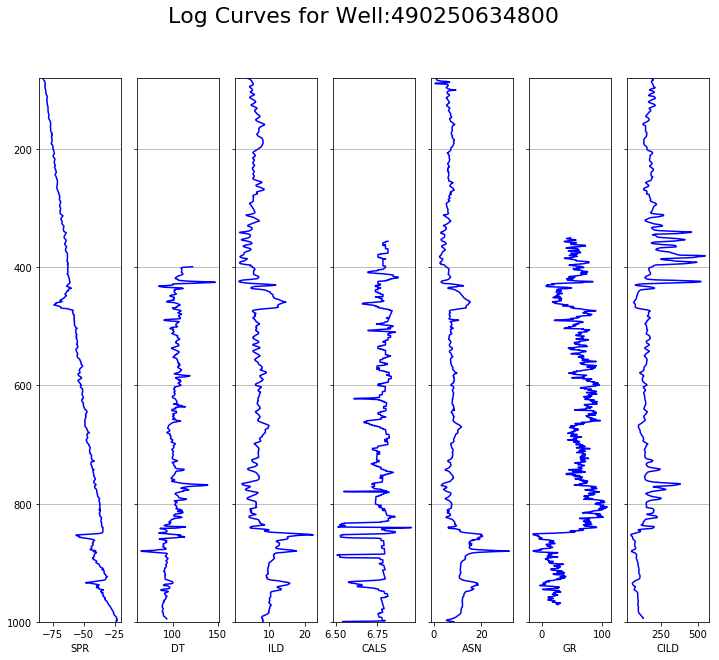

In [11]:
useSDK = True


if useSDK == True:
    
    login_instance = SWconnect.SWconnect("TeaPot-Demoset")

    depth_unit = SeisWare.Unit.Foot

    UWI = "490250634800"
    
    well = SWconnect.getWell(UWI,login_instance)

    data = get_all_log_curves(well,login_instance)

else:
    import lasio

    las = lasio.read(r'D:\Seismic\TeaPot-Demoset\490250634800.las')

    UWI = las.well.UWI.value
    
    data = las.df()
    

logs_plot(UWI,data,data.index.min(),data.index.max())


Let's look at some stats from the data, using the describe function in **Pandas**

In [12]:
data.describe()

,SPR,DT,ILD,CALS,ASN,GR,CILD
count,1841.000000,1193.000000,1841.000000,1289.000000,1841.000000,1243.000000,1829.000000
mean,-55.500935,100.970956,7.261565,6.771646,8.096883,55.329483,161.301516
std,15.245580,7.987604,2.729118,0.058376,3.424120,25.993619,68.383744
min,-82.728200,65.151900,1.630300,6.508900,0.439500,-14.652600,48.265500
25%,-68.821700,94.898000,5.596800,6.755100,6.201000,35.951650,128.535800
50%,-55.141600,101.611400,6.772500,6.784300,7.334500,61.468400,152.845400
75%,-42.347200,105.637700,8.234500,6.800300,8.707600,73.916700,183.706600
max,-22.850400,147.171300,22.336500,6.955100,31.810400,108.308200,548.584200


The values in my curves are currently all over the place, so I'm going to need to do some normalization before running my clustering. The clustering algorithms will work better if everything is on a similar scale. Fortunately I can use the StandardScaler in **scikit-learn** to normalize my dataframe in one step.

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
normData = StandardScaler().fit_transform(data)

pd.DataFrame(normData,columns=data.columns).describe()

,SPR,DT,ILD,CALS,ASN,GR,CILD
count,1.841000e+03,1.193000e+03,1.841000e+03,1.289000e+03,1.841000e+03,1.243000e+03,1.829000e+03
mean,-2.072095e-16,-5.218886e-16,3.528772e-16,5.540607e-15,-7.996500e-17,-1.672033e-16,3.496383e-16
std,1.000272e+00,1.000419e+00,1.000272e+00,1.000388e+00,1.000272e+00,1.000402e+00,1.000273e+00
min,-1.786397e+00,-4.486211e+00,-2.063962e+00,-4.502662e+00,-2.236915e+00,-2.693363e+00,-1.653418e+00
25%,-8.739834e-01,-7.606165e-01,-6.101670e-01,-2.835453e-01,-5.538352e-01,-7.457843e-01,-4.792758e-01
50%,2.357619e-02,8.021330e-02,-1.792514e-01,2.168535e-01,-2.227112e-01,2.362652e-01,-1.236906e-01
75%,8.630245e-01,5.844932e-01,3.565985e-01,4.910447e-01,1.784059e-01,7.153563e-01,3.277272e-01
max,2.142221e+00,5.786431e+00,5.525240e+00,3.143844e+00,6.927316e+00,2.038964e+00,5.664922e+00


Scikit-learn has a handful of clustering algorithms that can be used. I'm not going to go into very much detail on how they all work, but here's a link explaining more.

https://scikit-learn.org/stable/modules/clustering.html

I will do a little bit of exploratory data analysis on my log curves to see how a selection of these algorithms perform with some different datasets.

First I'll import the required libraries from **sklearn**.

In [15]:
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph

I'm going to define a function that can be used with an interactive ***widget*** in this notebook to take a look at how the clustering algorithms work with different pairs of curves, as well as with different numbers of clusters.

There's a bunch of code below, but that's because I'm looking at several algorithms at once and plotting the results.

Here's a list of the algorithms.

Mean Shift

Mini Batch K Means

Agglomerative Clustering (using Ward linkage)

Spectral Clustering

DBSCAN

Affinity Propagation

Agglomerative Clustering (using Average linkage)

Birch

In [16]:
import time
import matplotlib.colors as mcol

def plot_clusters(logX,logY,n_clusters):

    df = data[[logX,logY]].dropna()

    X = StandardScaler().fit_transform(df)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters)
    ward = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                                           connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.12)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",affinity="l1", n_clusters=n_clusters,
        connectivity=connectivity)

    birch = cluster.Birch(n_clusters=n_clusters)
    clustering_algorithms = [
        two_means, affinity_propagation, ms, spectral, ward, average_linkage,
        dbscan, birch]

    clustering_names = [
        'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
        'SpectralClustering', 'Ward', 'AgglomerativeClustering',
        'DBSCAN', 'Birch']
    plot_num = 1

    colors = np.array(['b','g','r','c','m','y','k','#B3B3B3','#996633',]*2)
    ccc = ['b','g','r','c','m','y','k','#B3B3B3','#996633',]
    cmap_facies = mcol.ListedColormap(colors[0:len(colors)], 'indexed')

    
    plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                        hspace=.01)

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        
        plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=8)
        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(df.columns[0])
        if plot_num == 1:
            plt.ylabel(df.columns[1])
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1


    
    plt.show()
    
    return

The ipywidgets library has an interactive option to help with my data exploration.

In [17]:
from ipywidgets import interactive

In [18]:
%matplotlib inline

interactive_plot = interactive(plot_clusters,
                               logX=data.columns,
                               logY=data.columns,
                               n_clusters = range(1,9))


Some of the algorithms depend on a number of clusters. For those that do, we can see how the the clusters vary.

In [19]:
interactive_plot

interactive(children=(Dropdown(description='logX', options=('SPR', 'DT', 'ILD', 'CALS', 'ASN', 'GR', 'CILD'), …

These are the results. Since all I'm doing is unsupervised clustering, my colours don't directly relate to anything. They can, however, be used to identify anomalies in my data, or particular zones of interest.

Lets take a look at two of these algorithms. K means and Spectral Clustering. I'll run them and show those results on a log curve plot.

First we'll retrieve the two log curves and merge them on MD.

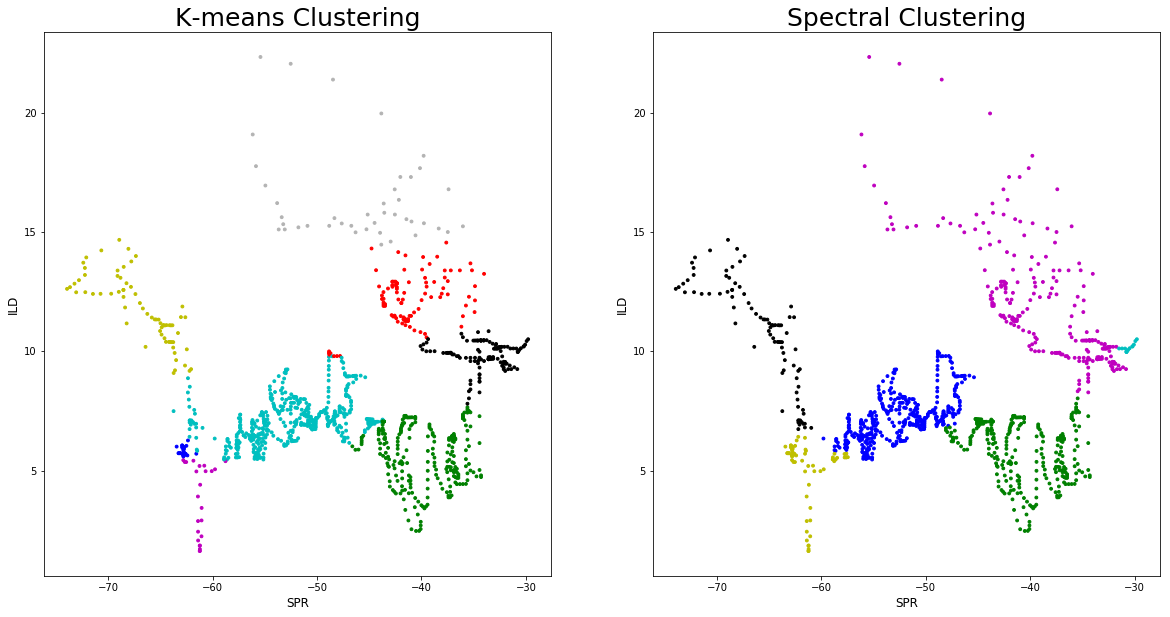

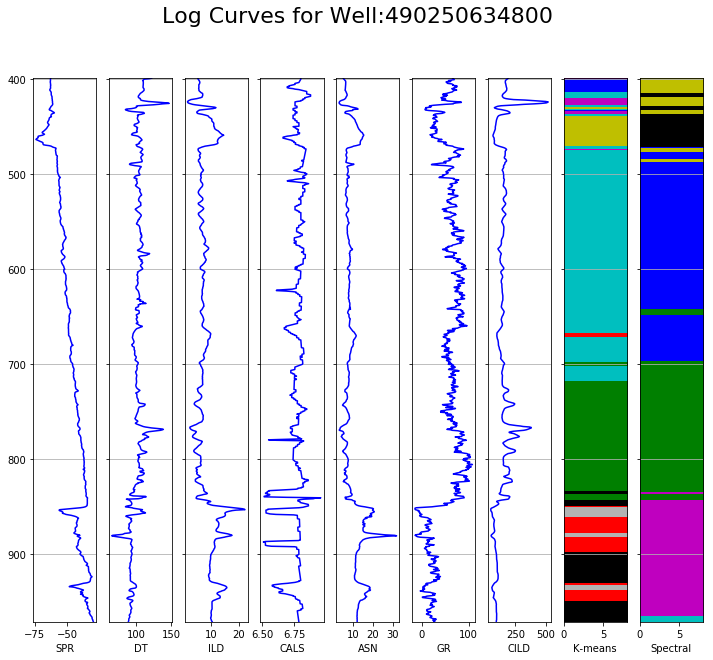

In [20]:
logX = "SPR"

logY = "ILD"

n_clusters = 8

# Create a cleaned DataFrame with only two columns and no null values

df = data[[logX,logY]].dropna().reset_index()

#Scale data and put it back in a dataframe

X = pd.DataFrame(StandardScaler().fit_transform(df.iloc[:,:]))

#Add column names back to newly scaled dataframe

X.columns = df.columns[:]

#Create the K-means and Spectral Clustering

two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters, n_init=100,batch_size=45,max_iter=200)

spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")

# Fit the clusters using both Spectral Clustering and Mini Batch Kmeans to compare

spectral.fit(X[[logX,logY]])

two_means.fit(X[[logX,logY]])

y_pred = two_means.labels_.astype(np.int)

y_pred_spectral = spectral.labels_.astype(np.int)

# Take the predicted labels and add them to the cleaned DataFrame (no nulls, only logX/logY)

df["K-means"] = pd.Series(y_pred)

df["Spectral"] = pd.Series(y_pred_spectral)

# Change the index from discrete values back to the Depth values

df = df.set_index("DEPT")

# Add the predicted labels back to the original DataFrame, matched on MD.

data['K-means'] = df['K-means']
data['Spectral'] = df['Spectral']

colors = np.array(['b','g','r','c','m','y','k','#B3B3B3',])

data.dropna(inplace=True)

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.scatter(data[logX], data[logY], color=colors[data['K-means'].astype(np.int)].tolist(), s=8)
plt.title("K-means Clustering", size = 25)
plt.xlabel(df.columns[0], size = 12)
plt.ylabel(df.columns[1], size = 12)
plt.subplot(1,2,2)
plt.scatter(data[logX], data[logY], color=colors[data['Spectral'].astype(np.int)].tolist(), s=8)
plt.title("Spectral Clustering", size = 25)
plt.xlabel(df.columns[0], size = 12)
plt.ylabel(df.columns[1], size = 12)

logs_plot(UWI,data,data.index.min(),data.index.max())


The curves are created with a set of discrete values. We can display them here in this notebook, but to compare it with my data more directly, I can send these cluster "curves" to SeisWare.

Here I'll define another function. Here I select a well, pick a cluster curve, and use my login instance for my project.

In [21]:
def clusters_to_SW(well,curve,login_instance):
    
    ### Takes in well by UWI, curve data from dataframe as a list and login instance of project
    
    wellObj = SWconnect.getWell(well,login_instance)
    
    newCurve = SeisWare.LogCurve()

    newCurve.SetValues(curve)

    newCurve.ParentID(wellObj.ID())

    newCurve.Name("K-means")

    newCurve.NullValue(-999.25)
    newCurve.DepthInc(SeisWare.Measurement(df.index.values[1]-df.index.values[0],depth_unit))

    newCurve.TopDepth(SeisWare.Measurement(df.index.min(),depth_unit))
    newCurve.BaseDepth(SeisWare.Measurement(df.index.max(),depth_unit))

    # Get the list of curves in the well to check if curve exists
    
    log_curve_list = SeisWare.LogCurveList()
    login_instance.LogCurveManager().GetAllForWell(wellObj.ID(), log_curve_list)

    if newCurve.Name() not in [i.Name() for i in log_curve_list]:
        login_instance.LogCurveManager().Add(newCurve)
    else:
        newCurve = [i for i in log_curve_list if i.Name()=="K-means"]
        login_instance.LogCurveManager().Update(newCurve[0])
    
    return 

Now we can run the function to output the curve to the desired UWI based on the login instance.

In [22]:

if useSDK == True:
    clusters_to_SW(UWI,df['K-means'].tolist(),login_instance)
    
    
else:
    import lasio
    las = lasio.read(r'D:\Seismic\TeaPot-Demoset\490250634800.las')

    las.set_data(data)
    UWI = las.well.UWI.value
    
    las.write("clusters.las")

Now we can head over to SeisWare to take a look at the results.

We've got a simple k-means cluster in SeisWare, but we can add some more complexity to the clustering without much more effort.

We had initially clustered the values based on two variables only, but the algorithm from **scikit-learn** works in 3 dimensions too.

Let's look at another well and use **RHOB, NPHI, and GRD**

In [23]:
UWI = '490251039200'

well3 = SWconnect.getWell(UWI,login_instance)

After defining the well, we can get all the log curves.

In [24]:
d3 = get_all_log_curves(well3,login_instance)

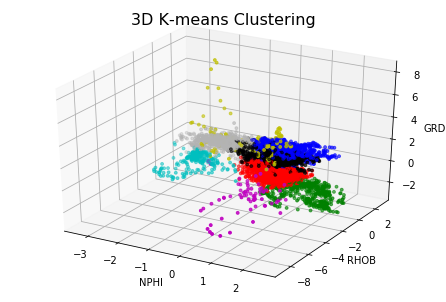

In [25]:
%matplotlib inline

logX = "NPHI"

logY = "RHOB"

logZ = "GRD"

n_clusters = 8

from mpl_toolkits.mplot3d import Axes3D

df = d3[[logX,logY,logZ]].dropna().reset_index()

#Scale data and put it back in a dataframe

X = pd.DataFrame(StandardScaler().fit_transform(df.iloc[:,:]))

#Add column names back to newly scaled dataframe

X.columns = df.columns[:]

#Create the K-means cluster

two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters,n_init = 100)

two_means.fit(X[[logX,logY,logZ]])

y_pred = two_means.labels_

df["K-means"] = pd.Series(y_pred)

fig = plt.figure()
ax = Axes3D(fig)
fig.suptitle('3D K-means Clustering', fontsize=16)

ax.scatter(X[logX],X[logY],X[logZ],c=df["K-means"],cmap = cmap_facies,s=8)
ax.set_xlabel(logX)
ax.set_ylabel(logY)
ax.set_zlabel(logZ)

df = df.set_index("DEPT")

Rather than selecting circles of data, in 3D we get spheres.

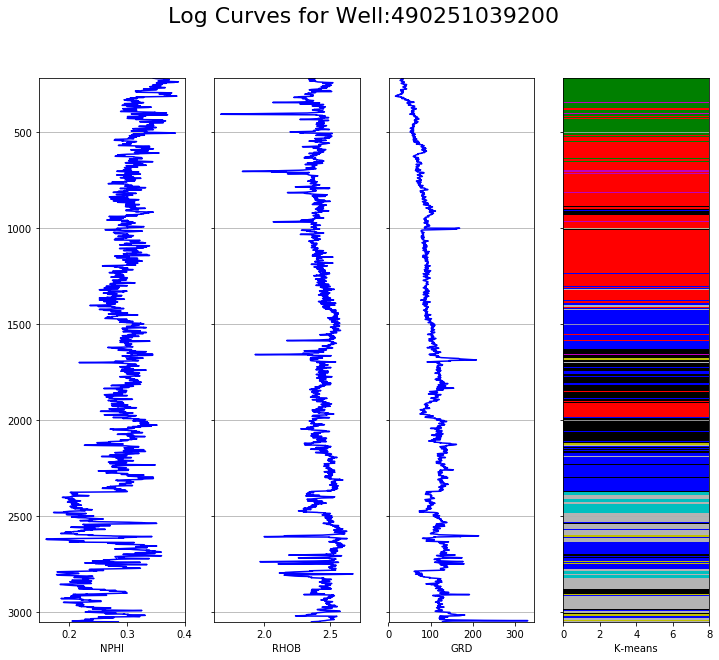

In [26]:
logs_plot(UWI,df,df.index.min(),df.index.max())

Now we can output the newly generated cluster curve to SeisWare


In [27]:

clusters_to_SW(UWI,df["K-means"].tolist(),login_instance)


And that is how to get log curve data from SeisWare, run a clustering algorithm on it, and get it back into SeisWare. There's a lot more details in the algorithms themselves that I didn't really get into, so take my results with a grain of salt. The main idea is to show what's possible between the SeisWare SDK and scikit-learn.